In [ ]:
#|default_exp speckles

# Speckles 

> Annoying and interesting paper inclusions 

In [ ]:
#|hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
#|hide 
import os

In [ ]:
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#|hide 
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.exposure as ske

from maxrf4u import DataStack

In [ ]:
#|hide 
ds = DataStack('RP-T-1898-A-3689.datastack') 
extent = ds.read('imvis_extent')
imvis = ds.read('imvis_reg_highres')

x_keVs = ds.read('maxrf_energies') 
y_max = ds.read('maxrf_maxspectrum')
y_sum = ds.read('maxrf_sumspectrum') 

hotmax_pixels = ds.read('hotmax_pixels')
hotmax_spectra = ds.read('hotmax_spectra')
hotmax_baselines = ds.read('hotmax_baselines')

peak_idxs = hotmax_pixels[:,2]

**I will continue working on this topic later...**

Historic handmade papers can contain various types of metal inclusions. Iron and manganese are abundantly present in groundwater and notoriously difficult to remove. Hence, historic papers typically contain iron/manganese inclusions. Another source of metal inclusions is the wear of paper making equipment such as the brass wires of a paper making mold. 

Metal inclusions in paper lead to spikes in the elemental maps computed from MA-XRF data. If one is interested in the distribution of elements due to media like ink, such spikes are annoying and need to be filtered out of the elemental maps. We will develop code here to do so. On the other hand, the composition and distribution of metal inclusions in paper is an interesting new source of information that might reveal details of the paper making process and help to distinguish different papers.  

## Brass 

When exploring the hotmax spectra in a previous section, hotmax spectra *12*, *13* and *14* showed an interesting combination of copper and zinc. Let's have a look these spectra and their pixel locations in combination with their corresponding elemental maps. 

In [ ]:
hotmax_pixels[[12, 13, 14]]

array([[489, 122, 900],
       [489, 122, 960],
       [489, 122, 984]])

Ah, these three hotmax pixels in our data cube are located at the same spatial location $(x,y)$ = (112, 489). Their spectra are identical and so we only need to look at hotmax spectrum *12*. 

In [ ]:
%matplotlib notebook

<IPython.core.display.Javascript object>


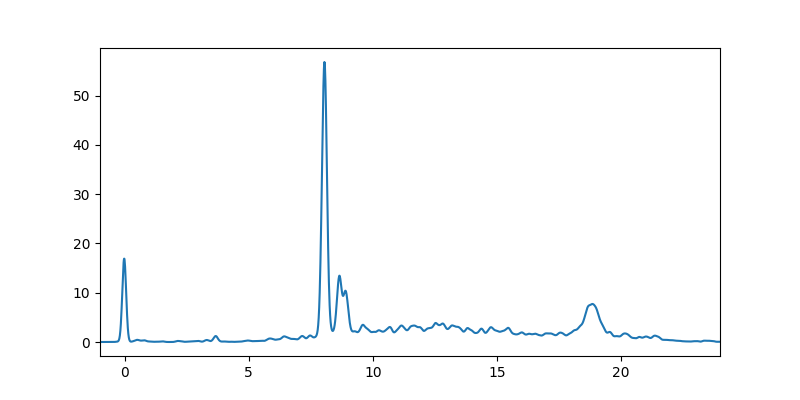

In [ ]:
#|code-fold: true 

from maxrf4u.peakmaps import _add_hotlines_ticklabels
y_hot = hotmax_spectra[12]

fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(x_keVs, y_hot)
ax.set_xlim([-1, 24]);


In [ ]:
y, x, z = hotmax_pixels[12]

In [ ]:
elements = ds.read('nmf_elements')
element_maps = ds.read('nmf_elementmaps')
element_maps_dict = dict(zip(elements, element_maps))

Cu_map = element_maps_dict['Cu']
Zn_map = element_maps_dict['Zn']

<IPython.core.display.Javascript object>


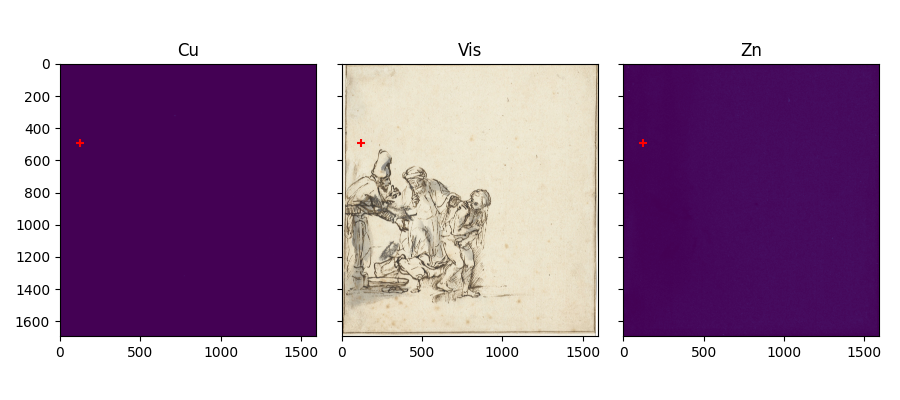

In [ ]:
fig, [ax0, ax1, ax2] = plt.subplots(sharex=True, sharey=True, ncols=3, figsize=[9, 4])

ax0.imshow(Cu_map)
ax0.scatter(x, y, color='r', marker='+')
ax0.set_title('Cu')

ax1.imshow(imvis, extent=extent)
ax1.scatter(x, y, color='r', marker='+')
ax1.set_title('Vis')


ax2.imshow(Zn_map)
ax2.scatter(x, y, color='r', marker='+')
ax2.set_title('Zn')

fig.tight_layout()

fig.show()


The trouble with speckles is, that they are too small to be noticed in the element maps. A simple way to make them visible is to apply a Gaussian blur filter.  

In [ ]:
import skimage.filters as skf

In [ ]:
Cu_map_gauss = skf.gaussian(Cu_map, sigma=5)
Zn_map_gauss = skf.gaussian(Zn_map, sigma=5)

<IPython.core.display.Javascript object>


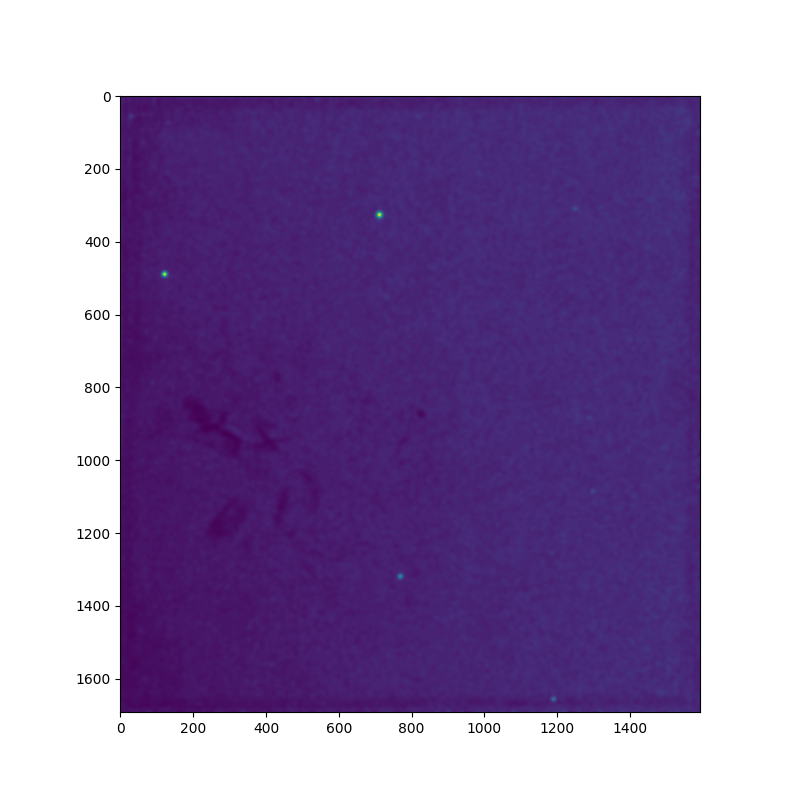

In [ ]:
fig, ax = plt.subplots(figsize=[8, 8])
ax.imshow(Cu_map_gauss);

<IPython.core.display.Javascript object>


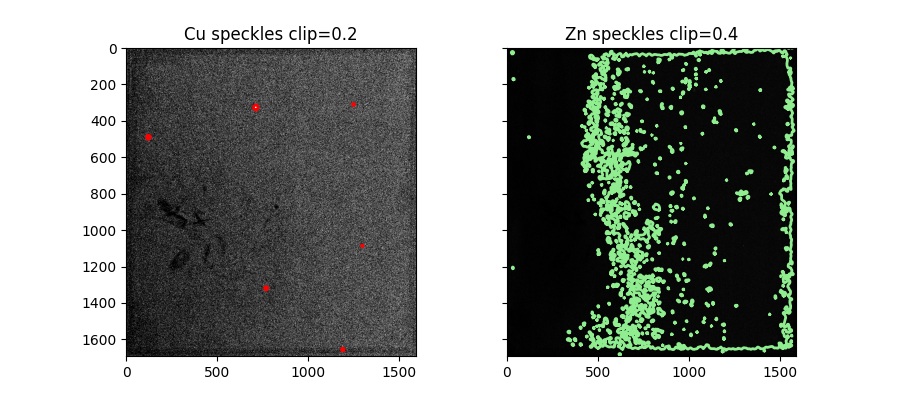

In [ ]:
Cu_clip = 0.2 
Cu_contours = skm.find_contours(Cu_map_gauss, Cu_clip*Cu_map_gauss.max())

Zn_clip = 0.4
Zn_contours = skm.find_contours(Zn_map_gauss, Zn_clip*Zn_map_gauss.max())


# Display the image and plot all contours found
fig, [ax, ax1] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[9, 4])
ax.imshow(Cu_map>Cu_clip, cmap=plt.cm.gray)

for contour in Cu_contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='r')

ax.axis('image')
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_title(f'Cu speckles clip={Cu_clip}')

ax1.imshow(Zn_map, cmap=plt.cm.gray)

for contour in Zn_contours:
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=2, color='lightgreen')

ax1.axis('image')
#ax.set_xticks([])
#ax.set_yticks([])
ax1.set_title(f'Zn speckles clip={Zn_clip}')


plt.show()

Mm, it is not so straightforward to locate zinc at the copper speckle locations. Do we have only one tiny brass particle???

In [ ]:
import skimage.measure as skm 
import numpy as np 

In [ ]:
class SpeckleAtlas(): 
    
    def __init__(self, peak_map, n_heights=100): 
        
        
        self.peak_map = peak_map 
        
        h, w = self.peak_map.shape
        self.n_px =  h * w 
        
        self.heights = np.linspace(peak_map.min(), peak_map.max(), n_heights)
        
        # perhaps better just iterate 
        height_maps = [self.peak_map > h for h in self.heights] 

        largest_area_list = [] 
        largest_label_list = []
        n_regions_list = []

        for i, hm in enumerate(height_maps): 

            print(f'Inspecting height slice: {i}/{n_heights}', end='\r')

            label_image = skm.label(height_maps[i].astype(int), connectivity=1)
            props = skm.regionprops(label_image)
            n_regions_list.append(len(props))
            areas_labels = np.array([[p.area, p.label] for p in props])

            label_image = skm.label(height_maps[i], connectivity=1)

            props = skm.regionprops(label_image)

            areas_labels = np.array([[p.area, p.label] for p in props])

            # in case of zero regions:  
            if len(areas_labels) == 0: 
                areas_labels = np.array([[0, 0]])

            areas, labels = areas_labels.T

            largest_area_i = np.argmax(areas)
            largest_area = areas[largest_area_i]
            largest_label = labels[largest_area_i]

            largest_area_list.append(largest_area)
            largest_label_list.append(largest_label) 
                
        
        self.largest_areas = largest_area_list   
        self.largest_labels = largest_label_list 
        self.n_regions = n_regions_list 

        
    def measure_speckles(self, max_area=100): 
        '''Find, sort, label and measure speckle regions.  
        
        Selects lowest height slice with all speckle regions smaller then *max_area*. 
        
        Returns: *clip_height* '''
        
        # find largest speckle and associated clip height 
        self.max_area = max_area 
        self.clip_height_i = np.argmin((np.array(self.largest_areas) - max_area)**2) 
        self.clip_height = self.heights[self.clip_height_i] 
        self.largest_speckle_label = self.largest_labels[self.clip_height_i] 
        
        # unsorted label image for clip level  
        unsorted_label_image = skm.label(self.peak_map > self.clip_height)
        uprops = skm.regionprops(unsorted_label_image) 

        u_areas = np.array([p.area for p in uprops])
        u_labels = np.array([p.label for p in uprops]) # [1, 2, 3 ...]

        # create area sorted labels 
        indices = np.argsort(u_areas)[::-1]
        area_sorted_labels = u_labels[indices]

        #prepend zero index for background 
        area_sorted_labels_bg = np.r_[0, area_sorted_labels]
        
        # make relabel lut 
        n_labels = len(area_sorted_labels_bg)
        relabel_lut = np.zeros(n_labels, dtype=int)
        
        # say region with label 123 is largest speckle 
        # then lut[123] = 1 
        relabel_lut[area_sorted_labels_bg] = np.arange(n_labels)
        
        # took me quite some time to debug so let's make sure next time 
        assert relabel_lut[area_sorted_labels_bg[1]] == 1, 'Relabeling of image went wrong' 
        
        self.relabel_image = relabel_lut[unsorted_label_image] 
        
        # determine region props 
        self.props = skm.regionprops(self.relabel_image, intensity_image=self.peak_map)
        
        self.centroids_y, self.centroids_x = np.array([p.centroid for p in self.props]).T
        self.centroids_xy = np.c_[self.centroids_x, self.centroids_y]
                                  
        return self.clip_height 
    
    
    def speckle_spectrum(self, arr, speckle_i): 
        '''Get averaged speckle spectrum for region of *speckle_i*. 
        
        Returns: *spectrum*
        -------
        '''

        print(speckle_i, end='\r')

        p = self.props[speckle_i]
        
        spectrum = region_spectra(arr, mask=p.image, average=True)
               
        return spectrum 
    